First, we prepare the notebook with the necessary packages to develop our model

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np
import seaborn as sns

## Business Understanding
From a point of view of a hattrick manager, is important to know beforehand the odds of his team winning the match given the ratings his team is capable of getting with his actual players.

Why? Because what a hattrick user wants to do every sunday when he plays a league match is to maximize the likelihood of him getting a victory over his rival team.

A hattrick user would like to calculate the possible outcome of his match so he can know which decisions to take.

We, as data scientist, are eager to help him or her achieve this objetive. With the help of data science we might be able to calculate his/her (maybe our own) probability of winning.

As stated in the forums and previoulsy spoken with hattrick users, the midfield rating is the most important single metric in a match.

We will help hattrick managers who read this article solving these questions:
* Hattrick user’s are good people, but we should not believe in their word just like that, so… Is midfield rating really the most important single metric in a match?
* Can Data Science help us define a Surpring Match?
What are the probabilities of winning given the ratings my team and the rival team have? (Information which they have beforehand)
Are the ratios between rival ratings better as features than the ratings themselves?
* How much of the odds depend solely on the midfield rating comparison (ratio)? In other words: How much do I control of the match’s odds by controlling the midfield only?
* On the contrary: how much of the odds depend on anything but the midfield rating comparison (ratio)? In other words: How predictable would be a match if I ignored the midfield?
* Sometimes, is inevitable to lose the midfield, what can a hattrick manager do if he/she loses the midfield rating ratio against his rival to increase his odds of winning the match?
* Can I respond the former questions with easy-to-interpret models or should I lose explainability to get better metrics?

## Gather
The first part of the data science process is to gather the information of the dataset(s) you will need to make your analysis. This part is given the existence of a hattrick matches dataset which was obtained with other module

In [280]:
# Read the dataset as a Pandas dataframe in memory
# Note: here, we only read the first 100K rows. Other sampling options are available
dataset_HT_Datos_prepared = pd.read_csv('/content/sample_data/Datos_HT.csv',sep=";")
df = dataset_HT_Datos_prepared
df.head()

,MatchId,Home midfield,Away midfield,Home Right Defence,Away Right Defence,Home Central Defence,Away Central Defence,Home Left Defence,Away Left Defence,Home Right Attack,Away Right Attack,Home Central Attack,Away Central Attack,Home Left Attack,Away Left Attack,Home Indirect Defence,Away Indirect Defence,Home Indirect Attack,Away Indirect Attack,Home Attitude,Away Attitude,Home Tactic,Away Tactic,Home Tactic Level,Away Tactic Level,Home Goals,Away Goals
0,631157390,12.0,6.0,14.0,7.0,18.0,7.0,17.0,5.0,7.0,8.0,5.0,9.0,6.0,6.0,15.0,9.0,14.0,10.0,(Hidden),(Hidden),Normal,Normal,(no tactic),(no tactic),8.0,0.0
1,631157391,5.0,4.0,5.0,5.0,5.0,7.0,6.0,6.0,6.0,6.0,6.0,5.0,8.0,6.0,6.0,8.0,7.0,9.0,(Hidden),(Hidden),Normal,Normal,(no tactic),(no tactic),3.0,2.0
2,631157392,4.0,3.0,4.0,6.0,7.0,6.0,8.0,3.0,7.0,7.0,6.0,5.0,5.0,7.0,8.0,7.0,9.0,8.0,(Hidden),(Hidden),Normal,Normal,(no tactic),(no tactic),4.0,2.0
3,631157393,7.0,11.0,7.0,16.0,7.0,17.0,5.0,17.0,8.0,16.0,9.0,7.0,6.0,20.0,9.0,16.0,10.0,16.0,(Hidden),(Hidden),Normal,Attack on wings,(no tactic),6,1.0,8.0
4,631157394,15.0,4.0,27.0,4.0,29.0,7.0,25.0,7.0,11.0,7.0,10.0,6.0,13.0,5.0,19.0,8.0,17.0,9.0,(Hidden),(Hidden),Play creatively,Normal,13,(no tactic),9.0,0.0


In [281]:
# The columns of the dataframe contain spaces ( ) which could difficult the
# handling of the columns, we replace the spaces for underlines (_) 
df.columns = df.columns.str.replace(" ","_")

In [282]:
# Show the head of the read dataset
df.head()

,MatchId,Home_midfield,Away_midfield,Home_Right_Defence,Away_Right_Defence,Home_Central_Defence,Away_Central_Defence,Home_Left_Defence,Away_Left_Defence,Home_Right_Attack,Away_Right_Attack,Home_Central_Attack,Away_Central_Attack,Home_Left_Attack,Away_Left_Attack,Home_Indirect_Defence,Away_Indirect_Defence,Home_Indirect_Attack,Away_Indirect_Attack,Home_Attitude,Away_Attitude,Home_Tactic,Away_Tactic,Home_Tactic_Level,Away_Tactic_Level,Home_Goals,Away_Goals
0,631157390,12.0,6.0,14.0,7.0,18.0,7.0,17.0,5.0,7.0,8.0,5.0,9.0,6.0,6.0,15.0,9.0,14.0,10.0,(Hidden),(Hidden),Normal,Normal,(no tactic),(no tactic),8.0,0.0
1,631157391,5.0,4.0,5.0,5.0,5.0,7.0,6.0,6.0,6.0,6.0,6.0,5.0,8.0,6.0,6.0,8.0,7.0,9.0,(Hidden),(Hidden),Normal,Normal,(no tactic),(no tactic),3.0,2.0
2,631157392,4.0,3.0,4.0,6.0,7.0,6.0,8.0,3.0,7.0,7.0,6.0,5.0,5.0,7.0,8.0,7.0,9.0,8.0,(Hidden),(Hidden),Normal,Normal,(no tactic),(no tactic),4.0,2.0
3,631157393,7.0,11.0,7.0,16.0,7.0,17.0,5.0,17.0,8.0,16.0,9.0,7.0,6.0,20.0,9.0,16.0,10.0,16.0,(Hidden),(Hidden),Normal,Attack on wings,(no tactic),6,1.0,8.0
4,631157394,15.0,4.0,27.0,4.0,29.0,7.0,25.0,7.0,11.0,7.0,10.0,6.0,13.0,5.0,19.0,8.0,17.0,9.0,(Hidden),(Hidden),Play creatively,Normal,13,(no tactic),9.0,0.0


In [283]:
# Definition of the Mutual Information
def mi_score(X,y,discrete_features):
    '''
    Estimates the Mutual Information score between a list of exogenous variables
    and an endogenous one.
    @param X: The parameter X gets the dataframe with information of the exogenous
     variables which we would like to obtain the Mutual Information Measure from
    @param y: The dataframe with the Y column which the X variables will be
     compared to.
    @param discrete_features: List of booleans, 
    @return: A table with the list of MI scores by variable
    '''
    mi_scores = mutual_info_regression(X,y,discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores,name="Mutual Info Scores",index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return(mi_scores)

# Data Understanding
Next, we will fill find a description of the dataset in which we will work

## Assess
After getting the dataset, the first part we, as data scientists, should complete is a description of the data we will be working on, metrics such as n, mean, standard deviation, minimum, percentiles and maximum can make a good approach to the data distribution

In [284]:
df.describe()

,MatchId,Home_midfield,Away_midfield,Home_Right_Defence,Away_Right_Defence,Home_Central_Defence,Away_Central_Defence,Home_Left_Defence,Away_Left_Defence,Home_Right_Attack,Away_Right_Attack,Home_Central_Attack,Away_Central_Attack,Home_Left_Attack,Away_Left_Attack,Home_Indirect_Defence,Away_Indirect_Defence,Home_Indirect_Attack,Away_Indirect_Attack,Home_Goals,Away_Goals
count,6.193000e+03,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000
mean,6.311605e+08,15.068296,12.704321,19.643146,19.672439,22.904030,23.022496,19.815990,19.861304,14.485515,14.638129,15.589739,15.557695,14.581971,14.723418,17.101311,17.094190,15.413335,15.359281,3.253763,2.837190
std,1.789380e+03,14.024289,11.714824,17.411433,17.651527,18.916414,19.290305,17.418551,17.666702,13.343614,13.297508,14.306902,13.975978,13.320350,13.271881,11.550252,11.572713,9.042348,8.974050,3.252066,3.229994
min,6.311574e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.311589e+08,5.000000,4.000000,6.000000,6.000000,7.000000,7.000000,6.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,8.000000,8.000000,8.000000,8.000000,0.000000,0.000000
50%,6.311605e+08,10.000000,8.000000,12.000000,12.000000,16.000000,16.000000,14.000000,14.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,15.000000,15.000000,14.000000,14.000000,2.000000,2.000000
75%,6.311620e+08,20.000000,17.000000,30.000000,29.000000,37.000000,37.000000,30.000000,30.000000,19.000000,19.000000,23.000000,23.000000,19.000000,20.000000,24.000000,23.500000,20.000000,20.000000,5.000000,5.000000
max,6.311636e+08,81.000000,68.000000,101.000000,94.000000,117.000000,109.000000,104.000000,97.000000,76.000000,85.000000,92.000000,86.000000,76.000000,78.000000,62.000000,60.000000,57.000000,57.000000,13.000000,13.000000


# Data Preparation
The preparation process consists in a simple cleaning process which will allow us to have the information prepared to measure the Mutual Information index

## Clean
For this project, the clean process is very simple: Elimination of some cases badly read, creation of new variables and the handling of some columns such as ID

In [285]:
# Creation of the Y variable defined as 1 if the Home team wins, 0 otherwise
df.loc[df.loc[:,'Home_Goals']>df.loc[:,'Away_Goals'],'Home_team_victory'] = 1
df.loc[df.loc[:,'Home_Goals']<=df.loc[:,'Away_Goals'],'Home_team_victory'] = 0

# Some matches were not correctly read, this line corrects it
df = df[(df['Home_midfield']>0) & (df['Away_midfield']>0)]

In [286]:
# MatchId is an ID column, which does not add information to the model
# Home Goals & Away Goals are variables which form the Y variable, for which can not be used to model
# Home Attitude & Away Attitude are columns that cannot be read for anyone different to the owner
df=df.loc[:,~df.columns.isin(["MatchId","Home_Goals","Away_Goals","Home_Attitude","Away_Attitude"])].replace("(no tactic)",np.NaN).fillna(0)

dfa = df #dfa is created to copy df without the changes for further analysis

df[['Home_Tactic_Level','Away_Tactic_Level']] = df[['Home_Tactic_Level','Away_Tactic_Level']].apply(pd.to_numeric,errors='coerce')
df=pd.get_dummies(df,columns=["Home_Tactic","Away_Tactic"]) # Converts the Tactics to dummy to be handled as numeric variables

In [287]:
df.describe()

,Home_midfield,Away_midfield,Home_Right_Defence,Away_Right_Defence,Home_Central_Defence,Away_Central_Defence,Home_Left_Defence,Away_Left_Defence,Home_Right_Attack,Away_Right_Attack,Home_Central_Attack,Away_Central_Attack,Home_Left_Attack,Away_Left_Attack,Home_Indirect_Defence,Away_Indirect_Defence,Home_Indirect_Attack,Away_Indirect_Attack,Home_Tactic_Level,Away_Tactic_Level,Home_team_victory,Home_Tactic_Attack in the Middle,Home_Tactic_Attack on wings,Home_Tactic_Counter-attacks,Home_Tactic_Long shots,Home_Tactic_Normal,Home_Tactic_Play creatively,Home_Tactic_Pressing,Away_Tactic_Attack in the Middle,Away_Tactic_Attack on wings,Away_Tactic_Counter-attacks,Away_Tactic_Long shots,Away_Tactic_Normal,Away_Tactic_Play creatively,Away_Tactic_Pressing
count,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000,6017.000000
mean,15.473990,13.046369,20.172013,20.202094,23.520691,23.642347,20.349510,20.396045,14.875519,15.032242,16.009473,15.976566,14.974572,15.119827,17.561742,17.554429,15.828320,15.772810,3.609440,3.888815,0.516370,0.063985,0.087585,0.047200,0.008144,0.727439,0.049360,0.016287,0.060994,0.084926,0.071132,0.008144,0.706997,0.047864,0.019943
std,13.989216,11.682013,17.339303,17.585922,18.787222,19.169745,17.341206,17.595698,13.305795,13.253674,14.264588,13.924603,13.278917,13.224651,11.354006,11.377765,8.797512,8.728035,6.354397,6.496017,0.499773,0.244747,0.282714,0.212083,0.089881,0.445314,0.216637,0.126588,0.239339,0.278795,0.257066,0.089881,0.455178,0.213497,0.139818
min,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,2.000000,3.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,4.000000,6.000000,6.000000,7.000000,7.000000,6.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,8.000000,8.000000,9.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.000000,9.000000,13.000000,13.000000,18.000000,18.000000,15.000000,15.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,16.000000,16.000000,14.000000,14.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,20.000000,18.000000,30.000000,30.000000,37.000000,37.000000,30.000000,30.000000,19.000000,20.000000,23.000000,23.000000,20.000000,20.000000,24.000000,24.000000,21.000000,21.000000,8.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,81.000000,68.000000,101.000000,94.000000,117.000000,109.000000,104.000000,97.000000,76.000000,85.000000,92.000000,86.000000,76.000000,78.000000,62.000000,60.000000,57.000000,57.000000,33.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Modelling
We prepared a function to measure the Information Index, this function works on any dataset

## Analyze
With the help of functions as Mutual Information, the relationship between exogenous and endogenous variables can be measured

In [ ]:
scor=mi_score(df.loc[:,~df.columns.isin(["Home_team_victory"])],df.Home_team_victory,discrete_features=True) #Apply MI_Score to the df

# Model
With the help of the plots of Mutual information scores, we proceed to measure and plot the relationship between X's & the Y

In [ ]:
def plot_mi_scores(scores):
    '''
    Plot Mutual Information Scores obtained
    @param scores: MI Scores previously obtained
    @return: Plot
    '''
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# Evaluation
The evaluation process can be asimilated to a process where we verify the information we generate is accord with the Business questions to be answered

# Visualize
Next, you will find a set of visualization which will help us solve the questions asked

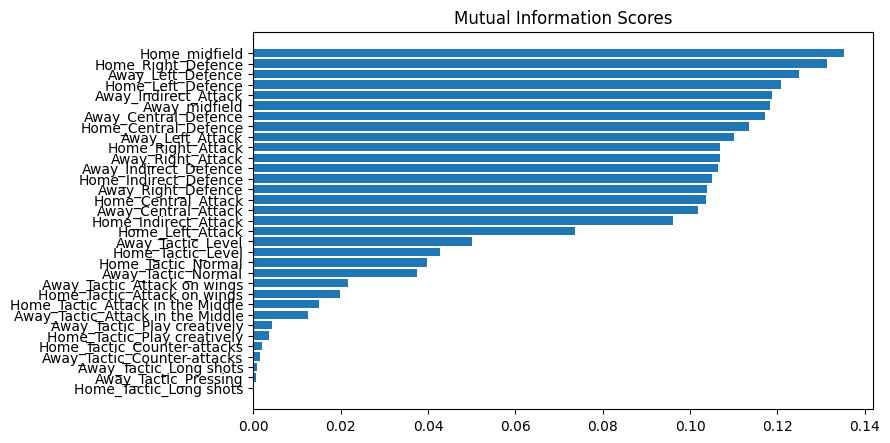

In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(scor[scor>0])

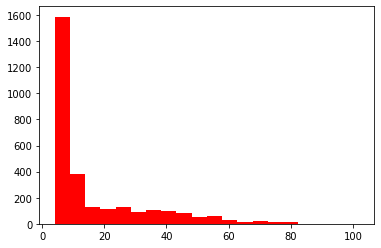

In [ ]:
# Plot the histogram of Home Central Defence for losing Home teams
plt.hist(df.Home_Central_Defence[df.Home_team_victory==0],orientation='vertical',bins=20,color='red')
plt.show()

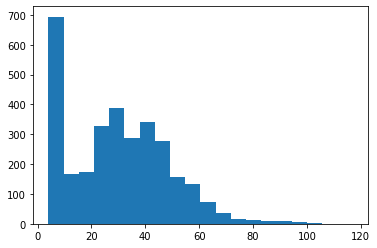

In [ ]:
# Plot the histogram of Home Central Defence for winning Home teams
plt.hist(df.Home_Central_Defence[df.Home_team_victory==1],orientation='vertical',bins=20,)
plt.show()

In [ ]:
# Creation of the new variables: Midfield ratio
df['Midfield_ratio'] = df['Home_midfield']/(df['Home_midfield']+df['Away_midfield'])

df['Central_Defence_vs_Attack'] = df['Home_Central_Defence']/(df['Home_Central_Defence']+df['Away_Central_Attack'])
df['Right_Defence_vs_Attack'] = df['Home_Right_Defence']/(df['Home_Right_Defence']+df['Away_Left_Attack'])
df['Left_Defence_vs_Attack'] = df['Home_Left_Defence']/(df['Home_Left_Defence']+df['Away_Right_Attack'])

df['Central_Attack_vs_Defence'] = df['Home_Central_Attack']/(df['Home_Central_Attack']+df['Away_Central_Defence'])
df['Right_Attack_vs_Defence'] = df['Home_Right_Attack']/(df['Home_Right_Attack']+df['Away_Left_Defence'])
df['Left_Attack_vs_Defence'] = df['Home_Left_Attack']/(df['Home_Left_Attack']+df['Away_Right_Defence'])

df['Indirect_Defence_vs_Attack'] = df['Home_Indirect_Defence']/(df['Home_Indirect_Defence']+df['Away_Indirect_Attack'])
df['Indirect_Attack_vs_Defence'] = df['Home_Indirect_Attack']/(df['Home_Indirect_Attack']+df['Away_Indirect_Defence'])

In [ ]:
# Sample of the dataset
df.head()

,Home_midfield,Away_midfield,Home_Right_Defence,Away_Right_Defence,Home_Central_Defence,Away_Central_Defence,Home_Left_Defence,Away_Left_Defence,Home_Right_Attack,Away_Right_Attack,Home_Central_Attack,Away_Central_Attack,Home_Left_Attack,Away_Left_Attack,Home_Indirect_Defence,Away_Indirect_Defence,Home_Indirect_Attack,Away_Indirect_Attack,Home_Tactic_Level,Away_Tactic_Level,Home_team_victory,Home_Tactic_Attack in the Middle,Home_Tactic_Attack on wings,Home_Tactic_Counter-attacks,Home_Tactic_Long shots,Home_Tactic_Normal,Home_Tactic_Play creatively,Home_Tactic_Pressing,Away_Tactic_Attack in the Middle,Away_Tactic_Attack on wings,Away_Tactic_Counter-attacks,Away_Tactic_Long shots,Away_Tactic_Normal,Away_Tactic_Play creatively,Away_Tactic_Pressing,Midfield_ratio,Central_Defence_vs_Attack,Right_Defence_vs_Attack,Left_Defence_vs_Attack,Central_Attack_vs_Defence,Right_Attack_vs_Defence,Left_Attack_vs_Defence,Indirect_Defence_vs_Attack,Indirect_Attack_vs_Defence
0,12.0,6.0,14.0,7.0,18.0,7.0,17.0,5.0,7.0,8.0,5.0,9.0,6.0,6.0,15.0,9.0,14.0,10.0,0,0,1.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.666667,0.666667,0.700000,0.680000,0.416667,0.583333,0.461538,0.600000,0.608696
1,5.0,4.0,5.0,5.0,5.0,7.0,6.0,6.0,6.0,6.0,6.0,5.0,8.0,6.0,6.0,8.0,7.0,9.0,0,0,1.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.555556,0.500000,0.454545,0.500000,0.461538,0.500000,0.615385,0.400000,0.466667
2,4.0,3.0,4.0,6.0,7.0,6.0,8.0,3.0,7.0,7.0,6.0,5.0,5.0,7.0,8.0,7.0,9.0,8.0,0,0,1.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.571429,0.583333,0.363636,0.533333,0.500000,0.700000,0.454545,0.500000,0.562500
3,7.0,11.0,7.0,16.0,7.0,17.0,5.0,17.0,8.0,16.0,9.0,7.0,6.0,20.0,9.0,16.0,10.0,16.0,0,6,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.388889,0.500000,0.259259,0.238095,0.346154,0.320000,0.272727,0.360000,0.384615
4,15.0,4.0,27.0,4.0,29.0,7.0,25.0,7.0,11.0,7.0,10.0,6.0,13.0,5.0,19.0,8.0,17.0,9.0,13,0,1.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.789474,0.828571,0.843750,0.781250,0.588235,0.611111,0.764706,0.678571,0.680000


In [ ]:
# Define X & Y

X_raw = df.loc[:,["Home_midfield","Away_midfield","Home_Right_Defence",
                  "Away_Right_Defence","Home_Central_Defence",
                  "Away_Central_Defence","Home_Left_Defence",
                  "Away_Left_Defence","Home_Right_Attack","Away_Right_Attack",
                  "Home_Central_Attack","Away_Central_Attack",
                  "Home_Left_Attack","Away_Left_Attack",
                  "Home_Indirect_Defence","Away_Indirect_Defence",
                  "Home_Indirect_Attack","Away_Indirect_Attack",
                  "Home_Tactic_Level","Away_Tactic_Level",
                  "Home_Tactic_Attack in the Middle",
                  "Home_Tactic_Attack on wings",
                  "Home_Tactic_Counter-attacks",
                  "Home_Tactic_Long shots","Home_Tactic_Normal",
                  "Home_Tactic_Play creatively",
                  "Home_Tactic_Pressing",
                  "Away_Tactic_Attack in the Middle",
                  "Away_Tactic_Attack on wings",
                  "Away_Tactic_Counter-attacks",
                  "Away_Tactic_Long shots","Away_Tactic_Normal",
                  "Away_Tactic_Play creatively",
                  "Away_Tactic_Pressing"]]

X = df.loc[:,["Midfield_ratio","Central_Defence_vs_Attack",
                         'Right_Defence_vs_Attack','Left_Defence_vs_Attack',
                         'Central_Attack_vs_Defence','Right_Attack_vs_Defence',
                         'Left_Attack_vs_Defence',
                         'Indirect_Defence_vs_Attack',
                         'Indirect_Attack_vs_Defence',
                         "Home_Tactic_Level","Away_Tactic_Level",
                         "Home_Tactic_Attack in the Middle",
                         "Home_Tactic_Attack on wings",
                         "Home_Tactic_Counter-attacks",
                         "Home_Tactic_Long shots","Home_Tactic_Normal",
                         "Home_Tactic_Play creatively",
                         "Home_Tactic_Pressing",
                         "Away_Tactic_Attack in the Middle",
                         "Away_Tactic_Attack on wings",
                         "Away_Tactic_Counter-attacks",
                         "Away_Tactic_Long shots","Away_Tactic_Normal",
                         "Away_Tactic_Play creatively",
                         "Away_Tactic_Pressing"]]

Y = df.Home_team_victory

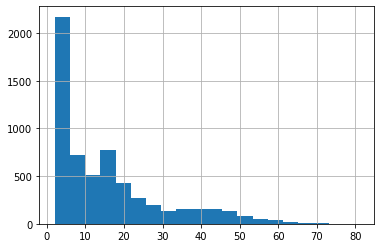

In [278]:
df.Home_midfield.hist(bins=20)

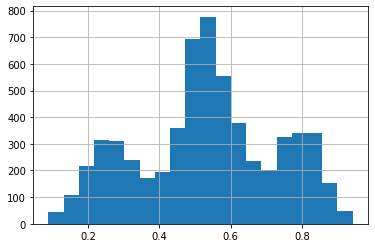

In [279]:
df.Midfield_ratio.hist(bins=20)

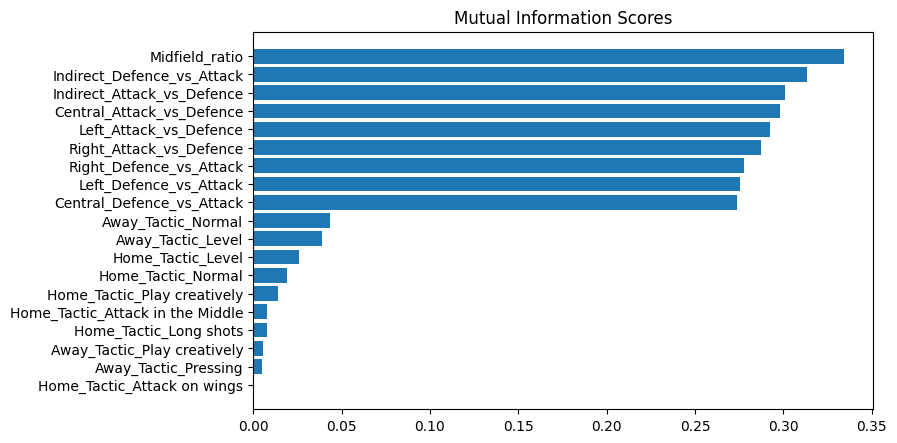

In [ ]:
# Calculation of Mutual Information taking into account the Midfield ratio & other top 3 variables
scor2=mi_score(X, Y, discrete_features=False)
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(scor2[scor2>0])

In [ ]:
# Import models and metrics for the modelling part
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from time import perf_counter 

In [ ]:
# Parameter grid for XGBoost
params = {'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10]}

folds = 3
param_comb = 45

In [ ]:
# Personalized function to get the thresold which optimizes the distance to the upper-left corner
def get_best_thre(Y,preds):
  '''
    Calculates the best threshold which minimizes the euclidean distance to the (0,1) point of the ROC curve
    @param Y: The column with the real label
    @param preds: Prediction of labels in probability
    
    @return: The threshold which minimizes the euclidean distance to the (0,1) point of the ROC curve
  '''
  fpr, tpr, thresholds = roc_curve(Y,preds)
  d = np.sqrt(fpr**2+(1-tpr)**2)
  return(thresholds[argmin(d)])

In [ ]:
# Personalized function to iterate throguht the models
def model_iteration(Model_name,Technique,Model,set_df):
  '''
    Fits a model, calculates the metrics: AUC, log-loss, 1-accuracy, feature importance (or coefficients) of the model
    and puts the information in a pandas dataframe for further analysis
    @param Model_name: Is the name of the question we are answering with the model
    @param Technique: Is a human-understandable way to describe the algorithm
    @param Model: Is the model object which will be understood by Python
    @param set_df: A list with X_train, X_test, Y_train, Y_test datasets where the techniques will be fitted and tested
    
    @return: A pandas dataframe with the information of every model, metrics and the object model to be called later
    '''
  start = perf_counter()
  
  # Special case: The exogenous variables dataset have only 1 columns
  
  if len(set_df[0].shape)==1:
    fitter = Model.fit(set_df[0].values.reshape(-1,1),set_df[2])
  else:
    fitter = Model.fit(set_df[0],set_df[2])
  end = perf_counter()
  time = end-start
  
  if len(set_df[0].shape)==1:
    pred_test = fitter.predict_proba(set_df[1].values.reshape(-1,1))[:,1]
  else:
    pred_test = fitter.predict_proba(set_df[1])[:,1]

  if len(set_df[0].shape)==1:
    set_df[0] = set_df[0].to_frame()

  auc = roc_auc_score(set_df[3],pred_test)
  logloss = log_loss(set_df[3],pred_test)
  best_thre = get_best_thre(set_df[3],pred_test)
  no_accuracy = accuracy_score(set_df[3],pred_test<best_thre)

  # Function is prepared to retrive best_estimator from GridSearch & Non-GridSearch
  if hasattr(fitter,'coef_'):
    Importance = pd.DataFrame({'Coefficient': fitter.coef_[0],'Abs_Coefficient': np.abs(fitter.coef_[0])}, index=set_df[0].columns).sort_values(by='Abs_Coefficient',ascending=False)
  elif hasattr(fitter,'feature_importances_'):
    Importance = pd.DataFrame(fitter.feature_importances_,set_df[0].columns,['Feature Importance']).sort_values(by='Feature Importance',ascending=False)
  elif hasattr(fitter,'best_estimator_'):
    if hasattr(fitter.best_estimator_,'coef_'):
      Importance = pd.DataFrame({'Coefficient': fitter.best_estimator_.coef_[0],'Abs_Coefficient': np.abs(fitter.best_estimator_.coef_[0])}, index=set_df[0].columns).sort_values(by='Abs_Coefficient',ascending=False)
    elif hasattr(fitter.best_estimator_,'feature_importances_'):
      Importance = pd.DataFrame(fitter.best_estimator_.feature_importances_,set_df[0].columns,['Feature Importance']).sort_values(by='Feature Importance',ascending=False)
    else:
      Importance = pd.DataFrame({'does not apply': [0]},index=['None'])
  else:
    Importance = pd.DataFrame({'does not apply': [0]},index=['None'])
  
  results = pd.DataFrame({'Model': [Model_name],
                          'Technique': [Technique],
                          'AUC': [auc],
                          'Log_Loss': [logloss],
                          'No_Accuracy': [no_accuracy],
                          'Influential_Feature': [Importance.index[0]],
                          'Method': [Importance.columns[0]],
                          'Value': [Importance[Importance.columns[0]][0]],
                          'Time elapsed (sec)': [time],
                          'Model Python': [Model]})
  
  if set_df[0].shape[1]==1:
    set_df[0] = set_df[0].squeeze()

  return(results)

In [ ]:
# Table to save results
results = pd.DataFrame({'Model': [], 'Technique': [], 'AUC': [], 
                        'Log_Loss': [], 'No_Accuracy': [],
                        'Influential_Feature': [],
                        'Method': [],
                        'Value': [],
                        'Time elapsed (sec)': [],
                        'Model Python': []})

# Models with raw variables

In [ ]:
# Variables for the model with raw variables
Model_name = 'Raw Variables'
X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(X_raw, Y, test_size=0.3, random_state=49)
set_df = [X_train_raw, X_test_raw, Y_train, Y_test]

In [ ]:
# Model with Logistic Regression

Technique = 'Logistic Regression'
Model = LogisticRegression(random_state=0,max_iter=10000)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Tree model

Technique = 'Decision tree'
Model = DecisionTreeClassifier()
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Random Forest Model

Technique = 'Random Forest. Depth = 2'
Model = RandomForestClassifier(max_depth=2, random_state=0)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Random Forest Model

Technique = 'Random Forest. Depth = 3'
Model = RandomForestClassifier(max_depth=3, random_state=0)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Bagging methods of KNN

Technique = 'Bagging of KNN'
Model = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5,bootstrap_features=True)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Neural Networks

Technique = 'Neural networks'
Model = MLPClassifier(random_state=1, max_iter=3000)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# XGBoost

Technique = "RandomSearch XGBoost"

xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=4)

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

Model = RandomizedSearchCV(xgb, param_distributions=params,
                                   n_iter=param_comb, scoring='neg_log_loss',
                                   n_jobs=4, cv=skf.split(set_df[0],set_df[2]),
                                   verbose=0, random_state=1901)

results = results.append(model_iteration(Model_name,Technique,Model,set_df))

# Models with all the generated features (of comparing field rates)

In [ ]:
# Datasets for the generated values
Model_name = "Generated features"
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=49)
set_df = [X_train, X_test, Y_train, Y_test]

In [ ]:
# Model with Logistic Regression

Technique = 'Logistic regression'
Model = LogisticRegression(random_state=0,max_iter=10000)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Tree model

Technique = 'Decision tree'
Model = DecisionTreeClassifier()
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Random Forest Model

Technique = 'Random Forest. Depth = 2'
Model = RandomForestClassifier(max_depth=2, random_state=0)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Random Forest Model - depth 3

Technique = 'Random Forest. Depth = 3'
Model = RandomForestClassifier(max_depth=3, random_state=0)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Bagging methods of KNN

Technique = "Bagging of KNN"
Model = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Neural Networks

Technique = 'Neural Networks'
Model = MLPClassifier(random_state=1, max_iter=3000)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
Technique = "RandomSearch XGBoost"

xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=4)

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

Model = RandomizedSearchCV(xgb, param_distributions=params,
                                   n_iter=param_comb, scoring='neg_log_loss',
                                   n_jobs=4, cv=skf.split(set_df[0],set_df[2]),
                                   verbose=0, random_state=1901)

results = results.append(model_iteration(Model_name,Technique,Model,set_df))

# Models with Midfield ratio only

In [ ]:
# Variables for the model with midfield ratio only
Model_name = 'Midfield ratio only'
X_train, X_test, Y_train, Y_test = train_test_split(X['Midfield_ratio'], Y, test_size=0.3, random_state=49)
set_df = [X_train, X_test, Y_train, Y_test]

In [ ]:
# Logistic Regression with only Midfield_ratio

Technique = 'Logistic Regression'
Model = LogisticRegression(random_state=0)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Tree model

Technique = 'Decision tree'
Model = DecisionTreeClassifier()
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Random Forest Model

Technique = 'Random Forest. Depth = 2'
Model = RandomForestClassifier(max_depth=2, random_state=0)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Random Forest Model

Technique = 'Random Forest. Depth = 3'
Model = RandomForestClassifier(max_depth=3, random_state=0)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Bagging methods of KNN

Technique = 'Bagging of KNN'
Model = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Neural Networks

Technique = "Neural networks"
Model = MLPClassifier(random_state=1, max_iter=3000)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# XGBoost

Technique = "RandomSearch XGBoost"

xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=False, nthread=4)

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

Model = RandomizedSearchCV(xgb, param_distributions=params,
                                   n_iter=param_comb, scoring='neg_log_loss',
                                   n_jobs=4, cv=skf.split(set_df[0],set_df[2]),
                                   verbose=0, random_state=1901)

results = results.append(model_iteration(Model_name,Technique,Model,set_df))

# Models without Midfield ratio

In [ ]:
# X train without midfield rating exogenous variable
Model_name = "Without midfield"
X_train_no_mid, X_test_no_mid, Y_train, Y_test = train_test_split(X.loc[:,~X.columns.isin(['Midfield_ratio'])], Y, test_size=0.3, random_state=49)
set_df = [X_train_no_mid, X_test_no_mid, Y_train, Y_test]

In [ ]:
#First model with Logistic Regression without Midfield_ratio

Technique = "Logistic Regression"
Model = LogisticRegression(random_state=0,max_iter=10000)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Tree model

Technique = "Decision Tree"
Model = DecisionTreeClassifier()
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Random Forest Model

Technique = 'Random Forest. Depth = 2'
Model = RandomForestClassifier(max_depth=2, random_state=0)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Random Forest Model

Technique = 'Random Forest. Depth = 3'
Model = RandomForestClassifier(max_depth=3, random_state=0)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Bagging methods of KNN
Technique = 'Bagging of KNN'
Model = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Neural Networks
Technique = "Neural Networks"
Model = MLPClassifier(random_state=1, max_iter=3000)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
Technique = "RandomSearch XGBoost"

xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=False, nthread=4)

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

Model = RandomizedSearchCV(xgb, param_distributions=params,
                                   n_iter=param_comb, scoring='neg_log_loss',
                                   n_jobs=4, cv=skf.split(set_df[0],set_df[2]),
                                   verbose=0, random_state=1901)

results = results.append(model_iteration(Model_name,Technique,Model,set_df))

# What to do if I lost the midfield?

In [ ]:
#Subset of matches where the Home Team lost the midfield
Model_name = "Lost midfield"
X_lost_mid = X.loc[X['Midfield_ratio']<0.5,:]
Y_lost_mid = Y.loc[X['Midfield_ratio']<0.5,]

# Retrieve of train/test subsets
set_df = [X_train_lost_mid, X_test_lost_mid, Y_train_lost_mid, Y_test_lost_mid]

In [ ]:
#First model with Logistic Regression with only Midfield_ratio

Technique = "Logistic Regression"

Model = LogisticRegression(random_state=0,max_iter=10000)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Tree model

Technique = 'Decision Tree'
Model = DecisionTreeClassifier()
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Random Forest Model

Technique = "Random Forest. Depth = 2"
Model = RandomForestClassifier(max_depth=2, random_state=0)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Random Forest Model

Technique = "Random Forest. Depth = 3"
Model = RandomForestClassifier(max_depth=3, random_state=0)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Bagging methods of KNN

Technique = "Bagging of KNN"
Model = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Neural Networks

Technique = "Neural Networks"
Model = MLPClassifier(random_state=1, max_iter=3000)
results = results.append(model_iteration(Model_name,Technique,Model,set_df))

In [ ]:
# Random search XGB
Technique = "RandomSearch XGBoost"

xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=False, nthread=4)

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

Model = RandomizedSearchCV(xgb, param_distributions=params,
                                   n_iter=param_comb, scoring='neg_log_loss',
                                   n_jobs=4, cv=skf.split(set_df[0],set_df[2]),
                                   verbose=0, random_state=1901)

results = results.append(model_iteration(Model_name,Technique,Model,set_df))

# Deployment
The deployment of the model is a presentation of the results in a blog, where this graphs and their interpretation are shown

In [ ]:
results

,Model,Technique,AUC,Log_Loss,No_Accuracy,Influential_Feature,Method,Value,Time elapsed (sec),Model Python
0,Raw Variables,Logistic Regression,0.940324,0.316327,0.132890,Home_Tactic_Attack on wings,Coefficient,0.560929,1.068373,"LogisticRegression(C=1.0, class_weight=None, d..."
0,Raw Variables,Decision tree,0.812970,6.445020,0.186600,Away_Central_Defence,Feature Importance,0.234712,0.046005,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
0,Raw Variables,Random Forest. Depth = 2,0.893881,0.405651,0.225360,Home_Central_Defence,Feature Importance,0.092432,0.261016,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
0,Raw Variables,Random Forest. Depth = 3,0.929735,0.369412,0.161683,Home_Central_Defence,Feature Importance,0.096111,0.306906,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
0,Raw Variables,Bagging of KNN,0.931234,0.315337,0.162791,None,does not apply,0.000000,0.074602,"(KNeighborsClassifier(algorithm='auto', leaf_s..."
0,Raw Variables,Neural networks,0.939440,0.320792,0.145072,None,does not apply,0.000000,2.761650,"MLPClassifier(activation='relu', alpha=0.0001,..."
0,Raw Variables,RandomSearch XGBoost,0.943958,0.325016,0.135105,Home_Central_Defence,Feature Importance,0.152409,71.747913,RandomizedSearchCV(cv=<generator object _BaseK...
0,Generated features,Logistic regression,0.946624,0.284360,0.135105,Midfield_ratio,Coefficient,9.654363,0.337147,"LogisticRegression(C=1.0, class_weight=None, d..."
0,Generated features,Decision tree,0.812897,6.425903,0.186047,Midfield_ratio,Feature Importance,0.518953,0.052624,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
0,Generated features,Random Forest. Depth = 2,0.944673,0.346445,0.136766,Central_Attack_vs_Defence,Feature Importance,0.199106,0.291816,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."


In [ ]:
# Which model should be followed:
results_1 = results.loc[(results['Model']=='Raw Variables') | (results['Model']=='Generated features'),:]
model_to_follow = results_1.iloc[argmin(results_1['Log_Loss']),:]
model_to_follow

Model                                                 Generated features
Technique                                                Neural Networks
AUC                                                             0.946005
Log_Loss                                                        0.283727
No_Accuracy                                                     0.133444
Influential_Feature                                                 None
Method                                                    does not apply
Value                                                                  0
Time elapsed (sec)                                               2.28358
Model Python           MLPClassifier(activation='relu', alpha=0.0001,...
Name: 0, dtype: object

In [ ]:
# Predictive power of Midfield
results_1 = results.loc[(results['Model']=='Midfield ratio only'),:]
model_midfield = results_1.iloc[argmin(results_1['Log_Loss']),:]
model_midfield

Model                                                Midfield ratio only
Technique                                                Neural networks
AUC                                                             0.916879
Log_Loss                                                        0.359606
No_Accuracy                                                     0.168882
Influential_Feature                                                 None
Method                                                    does not apply
Value                                                                  0
Time elapsed (sec)                                                1.9177
Model Python           MLPClassifier(activation='relu', alpha=0.0001,...
Name: 0, dtype: object

In [ ]:
# Without midfield
results_1 = results.loc[(results['Model']=='Without midfield'),:]
model_no_midfield = results_1.iloc[argmin(results_1['Log_Loss']),:]
model_no_midfield

Model                                                   Without midfield
Technique                                            Logistic Regression
AUC                                                             0.929989
Log_Loss                                                        0.316245
No_Accuracy                                                     0.165006
Influential_Feature                            Central_Attack_vs_Defence
Method                                                       Coefficient
Value                                                            4.94374
Time elapsed (sec)                                              0.312546
Model Python           LogisticRegression(C=1.0, class_weight=None, d...
Name: 0, dtype: object

In [ ]:
# Lost midfield
results_1 = results.loc[(results['Model']=='Lost midfield'),:]
model_lost_midfield = results_1.iloc[argmin(results_1['Log_Loss']),:]
model_lost_midfield

Model                                                      Lost midfield
Technique                                            Logistic Regression
AUC                                                             0.928023
Log_Loss                                                        0.162729
No_Accuracy                                                     0.139241
Influential_Feature                            Central_Defence_vs_Attack
Method                                                       Coefficient
Value                                                            2.49289
Time elapsed (sec)                                               0.12074
Model Python           LogisticRegression(C=1.0, class_weight=None, d...
Name: 0, dtype: object

In [ ]:
# Calculated probability of a hypothetical case

# Create an artificial dataset

Midfield_ratio = np.linspace(0,1,50)

X_art = pd.DataFrame({'Midfield_ratio': Midfield_ratio,
                      'Central_Defence_vs_Attack': [X.Central_Defence_vs_Attack.mean()]*50,
                      'Right_Defence_vs_Attack': [X.Right_Defence_vs_Attack.mean()]*50,
                      'Left_Defence_vs_Attack': [X.Left_Defence_vs_Attack.mean()]*50,
                      'Central_Attack_vs_Defence': [X.Central_Attack_vs_Defence.mean()]*50,
                      'Right_Attack_vs_Defence': [X.Right_Attack_vs_Defence.mean()]*50,
                      'Left_Attack_vs_Defence': [X.Left_Attack_vs_Defence.mean()]*50,
                      'Indirect_Defence_vs_Attack': [X.Indirect_Defence_vs_Attack.mean()]*50,
                      'Indirect_Attack_vs_Defence': [X.Indirect_Attack_vs_Defence.mean()]*50,
                      'Home_Tactic_Level': [X.Home_Tactic_Level.mean()]*50,
                      'Away_Tactic_Level': [X.Away_Tactic_Level.mean()]*50,
                      'Home_Tactic_Attack in the Middle': [X['Home_Tactic_Attack in the Middle'].mean()]*50,
                      'Home_Tactic_Attack on wings': [X['Home_Tactic_Attack on wings'].mean()]*50,
                      'Home_Tactic_Counter-attacks': [X['Home_Tactic_Counter-attacks'].mean()]*50,
                      'Home_Tactic_Long shots': [X['Home_Tactic_Long shots'].mean()]*50,
                      'Home_Tactic_Normal': [X.Home_Tactic_Normal.mean()]*50,
                      'Home_Tactic_Play creatively': [X['Home_Tactic_Play creatively'].mean()]*50,
                      'Home_Tactic_Pressing': [X.Home_Tactic_Pressing.mean()]*50,
                      'Away_Tactic_Attack in the Middle': [X['Away_Tactic_Attack in the Middle'].mean()]*50,
                      'Away_Tactic_Attack on wings': [X['Away_Tactic_Attack on wings'].mean()]*50,
                      'Away_Tactic_Counter-attacks': [X['Away_Tactic_Counter-attacks'].mean()]*50,
                      'Away_Tactic_Long shots': [X['Away_Tactic_Long shots'].mean()]*50,
                      'Away_Tactic_Normal': [X.Away_Tactic_Normal.mean()]*50,
                      'Away_Tactic_Play creatively': [X['Away_Tactic_Play creatively'].mean()]*50,
                      'Away_Tactic_Pressing': [X.Away_Tactic_Pressing.mean()]*50})

P=model_to_follow['Model Python'].predict_proba(X_art)[:,1]

mf_only = pd.DataFrame({'x': Midfield_ratio, 'y': P})

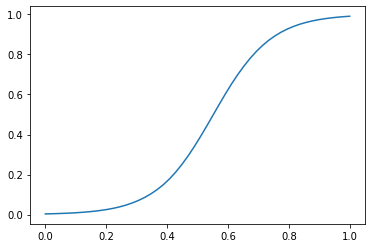

In [ ]:
show(plot(mf_only.x,mf_only.y))

Model                                                Midfield ratio only
Technique                                                Neural networks
AUC                                                             0.916879
Log_Loss                                                        0.359606
No_Accuracy                                                     0.168882
Influential_Feature                                                 None
Method                                                    does not apply
Value                                                                  0
Time elapsed (sec)                                                1.9177
Model Python           MLPClassifier(activation='relu', alpha=0.0001,...
Name: 0, dtype: object

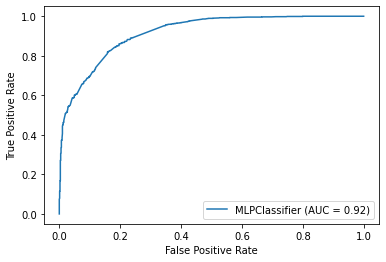

In [ ]:
# How much of the odds depend solely on the midfield rating comparison (ratio)?
# In other words: How much do I control of the match's odds by controlling the midfield only?

Model_name = 'Midfield ratio only'
X_train, X_test, Y_train, Y_test = train_test_split(X['Midfield_ratio'], Y, test_size=0.3, random_state=49)
set_df = [X_train, X_test, Y_train, Y_test]

metrics.plot_roc_curve(model_midfield['Model Python'], X_test.values.reshape(-1,1), Y_test)

model_midfield

Model                                                   Without midfield
Technique                                            Logistic Regression
AUC                                                             0.929989
Log_Loss                                                        0.316245
No_Accuracy                                                     0.165006
Influential_Feature                            Central_Attack_vs_Defence
Method                                                       Coefficient
Value                                                            4.94374
Time elapsed (sec)                                              0.312546
Model Python           LogisticRegression(C=1.0, class_weight=None, d...
Name: 0, dtype: object

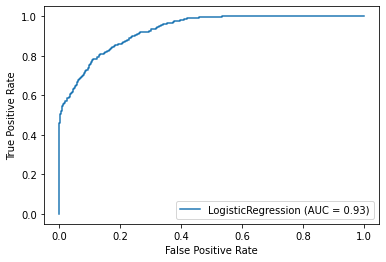

In [ ]:
Model_name = 'Without midfield'
X_train, X_test, Y_train, Y_test = train_test_split(X.loc[:,~X.columns.isin(['Midfield_ratio'])], Y, test_size=0.3, random_state=49)
set_df = [X_train, X_test, Y_train, Y_test]

metrics.plot_roc_curve(model_no_midfield['Model Python'], X_test, Y_test)
model_no_midfield

Model                                                      Lost midfield
Technique                                            Logistic Regression
AUC                                                             0.928023
Log_Loss                                                        0.162729
No_Accuracy                                                     0.139241
Influential_Feature                            Central_Defence_vs_Attack
Method                                                       Coefficient
Value                                                            2.49289
Time elapsed (sec)                                               0.12074
Model Python           LogisticRegression(C=1.0, class_weight=None, d...
Name: 0, dtype: object

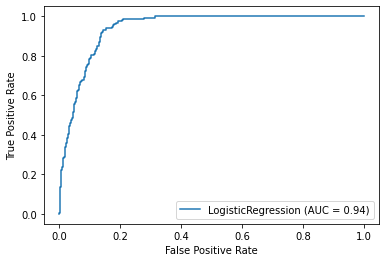

In [ ]:
Model_name = 'Lost midfield'
X_lost_mid = X.loc[X['Midfield_ratio']<0.5,:]
Y_lost_mid = Y.loc[X['Midfield_ratio']<0.5,]

metrics.plot_roc_curve(model_lost_midfield['Model Python'], X_lost_mid, Y_lost_mid)
model_lost_midfield

In [ ]:
# Is midfield still important even when is lost?

Midfield_ratio = np.linspace(0,0.5,50)

X_art = pd.DataFrame({'Midfield_ratio': Midfield_ratio,
                      'Central_Defence_vs_Attack': [X.Central_Defence_vs_Attack.mean()]*50,
                      'Right_Defence_vs_Attack': [X.Right_Defence_vs_Attack.mean()]*50,
                      'Left_Defence_vs_Attack': [X.Left_Defence_vs_Attack.mean()]*50,
                      'Central_Attack_vs_Defence': [X.Central_Attack_vs_Defence.mean()]*50,
                      'Right_Attack_vs_Defence': [X.Right_Attack_vs_Defence.mean()]*50,
                      'Left_Attack_vs_Defence': [X.Left_Attack_vs_Defence.mean()]*50,
                      'Indirect_Defence_vs_Attack': [X.Indirect_Defence_vs_Attack.mean()]*50,
                      'Indirect_Attack_vs_Defence': [X.Indirect_Attack_vs_Defence.mean()]*50,
                      'Home_Tactic_Level': [X.Home_Tactic_Level.mean()]*50,
                      'Away_Tactic_Level': [X.Away_Tactic_Level.mean()]*50,
                      'Home_Tactic_Attack in the Middle': [X['Home_Tactic_Attack in the Middle'].mean()]*50,
                      'Home_Tactic_Attack on wings': [X['Home_Tactic_Attack on wings'].mean()]*50,
                      'Home_Tactic_Counter-attacks': [X['Home_Tactic_Counter-attacks'].mean()]*50,
                      'Home_Tactic_Long shots': [X['Home_Tactic_Long shots'].mean()]*50,
                      'Home_Tactic_Normal': [X.Home_Tactic_Normal.mean()]*50,
                      'Home_Tactic_Play creatively': [X['Home_Tactic_Play creatively'].mean()]*50,
                      'Home_Tactic_Pressing': [X.Home_Tactic_Pressing.mean()]*50,
                      'Away_Tactic_Attack in the Middle': [X['Away_Tactic_Attack in the Middle'].mean()]*50,
                      'Away_Tactic_Attack on wings': [X['Away_Tactic_Attack on wings'].mean()]*50,
                      'Away_Tactic_Counter-attacks': [X['Away_Tactic_Counter-attacks'].mean()]*50,
                      'Away_Tactic_Long shots': [X['Away_Tactic_Long shots'].mean()]*50,
                      'Away_Tactic_Normal': [X.Away_Tactic_Normal.mean()]*50,
                      'Away_Tactic_Play creatively': [X['Away_Tactic_Play creatively'].mean()]*50,
                      'Away_Tactic_Pressing': [X.Away_Tactic_Pressing.mean()]*50})

P=model_lost_midfield['Model Python'].predict_proba(X_art)[:,1]

mf_lost = pd.DataFrame({'x': Midfield_ratio, 'y': P})

In [ ]:
# What if... Midfield lost + Central Defence won

Midfield_ratio = np.linspace(0,0.5,50)

X_art = pd.DataFrame({'Midfield_ratio': Midfield_ratio,
                      'Central_Defence_vs_Attack': [X.Central_Defence_vs_Attack.quantile(q=0.75)]*50,
                      'Right_Defence_vs_Attack': [X.Right_Defence_vs_Attack.mean()]*50,
                      'Left_Defence_vs_Attack': [X.Left_Defence_vs_Attack.mean()]*50,
                      'Central_Attack_vs_Defence': [X.Central_Attack_vs_Defence.mean()]*50,
                      'Right_Attack_vs_Defence': [X.Right_Attack_vs_Defence.mean()]*50,
                      'Left_Attack_vs_Defence': [X.Left_Attack_vs_Defence.mean()]*50,
                      'Indirect_Defence_vs_Attack': [X.Indirect_Defence_vs_Attack.mean()]*50,
                      'Indirect_Attack_vs_Defence': [X.Indirect_Attack_vs_Defence.mean()]*50,
                      'Home_Tactic_Level': [X.Home_Tactic_Level.mean()]*50,
                      'Away_Tactic_Level': [X.Away_Tactic_Level.mean()]*50,
                      'Home_Tactic_Attack in the Middle': [X['Home_Tactic_Attack in the Middle'].mean()]*50,
                      'Home_Tactic_Attack on wings': [X['Home_Tactic_Attack on wings'].mean()]*50,
                      'Home_Tactic_Counter-attacks': [X['Home_Tactic_Counter-attacks'].mean()]*50,
                      'Home_Tactic_Long shots': [X['Home_Tactic_Long shots'].mean()]*50,
                      'Home_Tactic_Normal': [X.Home_Tactic_Normal.mean()]*50,
                      'Home_Tactic_Play creatively': [X['Home_Tactic_Play creatively'].mean()]*50,
                      'Home_Tactic_Pressing': [X.Home_Tactic_Pressing.mean()]*50,
                      'Away_Tactic_Attack in the Middle': [X['Away_Tactic_Attack in the Middle'].mean()]*50,
                      'Away_Tactic_Attack on wings': [X['Away_Tactic_Attack on wings'].mean()]*50,
                      'Away_Tactic_Counter-attacks': [X['Away_Tactic_Counter-attacks'].mean()]*50,
                      'Away_Tactic_Long shots': [X['Away_Tactic_Long shots'].mean()]*50,
                      'Away_Tactic_Normal': [X.Away_Tactic_Normal.mean()]*50,
                      'Away_Tactic_Play creatively': [X['Away_Tactic_Play creatively'].mean()]*50,
                      'Away_Tactic_Pressing': [X.Away_Tactic_Pressing.mean()]*50})

P=model_lost_midfield['Model Python'].predict_proba(X_art)[:,1]

mf_lost = pd.DataFrame({'x': Midfield_ratio, 'y': P})

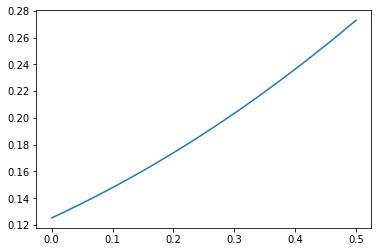

In [ ]:
show(plot(mf_lost.x,mf_lost.y))

In [ ]:
https://github.com/juanes8400/ht_matches_2